## SEN163A - Fundamentals of Data Analytics
## Assignment 1 - Data consistency
### Ir. Jacopo De Stefani - [J.deStefani@tudelft.nl](mailto:J.deStefani@tudelft.nl)
### Joao Pizani Flor, M.Sc. - [J.p.pizaniflor@tudelft.nl](mailto:J.p.pizaniflor@tudelft.nl)

## Group 6
- Jonathan D. Ambrose - ''5266343''
- Luisa de La Vega - ''5584698''
- Rianne Ouderkerken - ''5669758''
- Thomas Steurbaut  - ''5456282''

# 1. Introduction 

Fraud detection in payment transactions is a growing challenge [1]. In order to solve this problem, several techniques such as regression analysis, machine learning, and pattern recognition are generally used. The main goal of this assignment is to check the consistency of the dataset provided and identify all potential fraudulent activities within it. We use an exploratory data analysis approach. First the dataset is described and hereafter analysed for inconsistencies. For the later exploratory techniques and visualisations are also used to uncover potential fraud. Thereafter potential fraud cases are explained.

# 2. Dataset Description

This phase of the project is essential to understand the data provided and consequently highlight possible methods and techniques to identify fraudulent activities in the dataset. Firstly, the transactions data file is imported, read and the two first rows are previewed.

In [15]:
#%run db.py

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np 

import collections
from collections import defaultdict
import random as random
import sys

import math
from decimal import Decimal

import benford as bf #pip3 install benford_py

In [16]:
def display_format(n):
    """Function to control the displayed format of decimals in pandas DataFrames"""
    n = '.' + str(n) ; f = '{:,' + n + 'f}'
    pd.options.display.float_format = f.format

In [17]:
#control display
display_format(3)

In [18]:
#read csv that was made by running the db.py file.  
transcations = pd.read_csv('transactions.csv', index_col = 0)

In [19]:
#Now we display the Dataframe. We can read the column names and see that there are transaction amounts from an orginating account to a destination account. 
#This includeses the name and balances of each account before an after the transaction. 
transcations[:2]

type    amount     nameOrig  oldbalanceOrig  newbalanceOrig  \
timestamp                                                                    
1          TRANSFER     0.010  C1231006815     170,136.000     170,135.990   
1          TRANSFER 9,839.640  C1231006815     170,136.000     160,296.360   

              nameDest  oldbalanceDest  newbalanceDest  
timestamp                                               
1            C52983754           0.010           0.020  
1          M1979787155           0.000       9,839.630

The command transcations.info() gives the shape of the dataset and then, the number of columns and rows within it. The data types for each column are also identified. 

In [20]:
transcations.info()
# see data's shape (number of columns and rows). Also see the data type per column. 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7734834 entries, 1 to 743
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   type            object 
 1   amount          float64
 2   nameOrig        object 
 3   oldbalanceOrig  float64
 4   newbalanceOrig  float64
 5   nameDest        object 
 6   oldbalanceDest  float64
 7   newbalanceDest  float64
dtypes: float64(5), object(3)
memory usage: 531.1+ MB


Then, the command transcations.describe() is used to identify the maximum, minimum, mean, and 25%, 50%, and 75% values. It helps to find patterns within the dataset, identify the ranges of these data and then, draw an overview of the transactions data. 

In [21]:
transcations.describe()
#see the max,min, 50%, mean and std of each column. 

#note the highest amount transfered is 92 million while the least amount transfered is zero.

amount  oldbalanceOrig  newbalanceOrig  oldbalanceDest  \
count  7,734,834.000   7,734,834.000   7,734,834.000   7,734,834.000   
mean     147,953.140     833,980.169     686,027.027   1,297,192.744   
std      551,973.921   2,890,094.986   2,943,680.736   3,441,619.364   
min            0.000 -46,211,920.920 -92,445,516.640  -4,366,622.920   
25%        3,954.593           0.000    -107,211.990           0.000   
50%       34,245.655      14,164.000      -2,773.930      13,307.285   
75%      174,462.780     107,352.000      62,960.632   1,277,120.780   
max   92,445,516.640  77,430,968.380  77,428,942.490 357,277,441.820   

       newbalanceDest  
count   7,734,834.000  
mean    1,445,145.881  
std     3,647,219.765  
min    -4,234,680.130  
25%         8,961.312  
50%       183,055.740  
75%     1,514,394.050  
max   357,440,831.380

It is identified that the highest amount transferred is 92 million while the least amount transferred is zero. Furthermore, negative numbers are investigated in the Data Consistency section.

In [22]:
col_names = [column for column in transcations.columns]
print('column names are... ',col_names)

transcations[col_names[0]].unique()

column names are...  ['type', 'amount', 'nameOrig', 'oldbalanceOrig', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest']


array(['TRANSFER'], dtype=object)

This took 25 minutes to run. Please skip it if you rerun. 

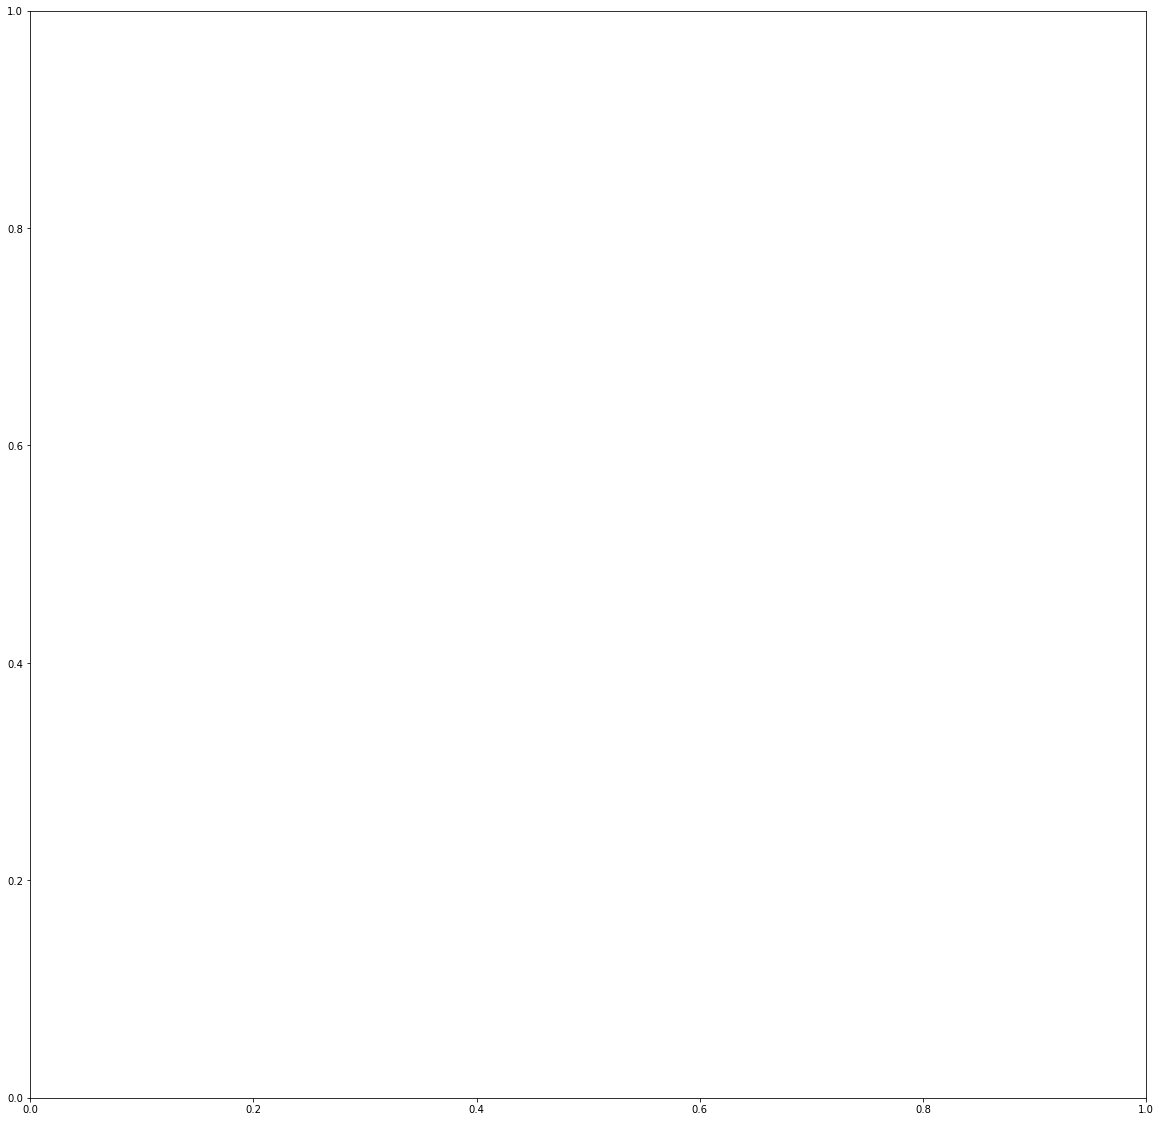

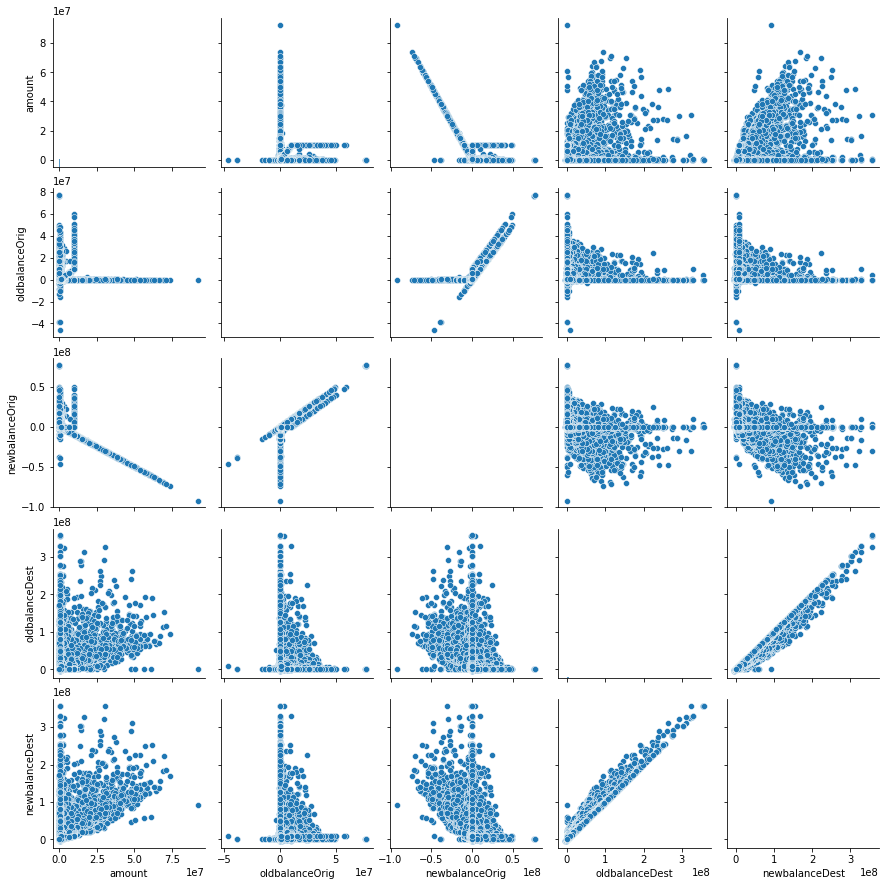

In [23]:
f,ax = plt.subplots(figsize = (20,20))
sns.pairplot(transcations)
plt.show()

#The pair plot shows that originator and destination accounts have a linear relationship
# ... with respect to their old and new balances. We expect this. 

# 3. Dataset Consistency

In this section it is analysed the consistency of the dataset since it can be considered crucial for decision support, as decision-making is typically based on data values [2]. Regarding this project, the consistency of the data is considered one of the main aspects to identify fraudulent transactions.

First, we check for missing data.

In [24]:
#Check for missing data first
transcations.isnull().value_counts() #no missing data. But could be wrong negative numbers or zeros.

type   amount  nameOrig  oldbalanceOrig  newbalanceOrig  nameDest  oldbalanceDest  newbalanceDest
False  False   False     False           False           False     False           False             7734834
dtype: int64

### I.  Benford's Law
The transaction amounts are checked whether they follow Benford’s Law [3]. This law is the finding that the first digits of numbers in a variety of records do not have a uniform distribution but a pattern where the digit ‘1’ is more frequent, then the digit ‘2’, ‘3’, and so on to 9. It is an effective tool for testing data quality, identifying anomalous data and is a principal used in fraud detection [4]. Then, the amount transfers consistency is verified. 

amount

Initialized sequence with 7734818 registries.

Test performed on 7734818 registries.
Discarded 0 records < 1 after preparation.


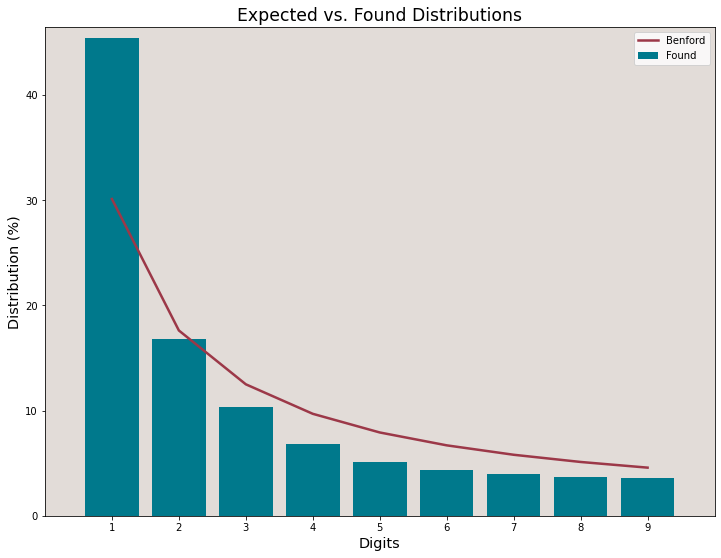

In [25]:
#sort dataframe and convert to numpy array for speed
bf_amounts = transcations.amount.sort_values().to_numpy()
#calculate benford 
print('amount')
benford_amounts = bf.first_digits(bf_amounts, digs=1, decimals='infer') # digs=1 for the first digit (1-9)


#below we see to many amounts starting with 1. 

Old destination Balance

Initialized sequence with 5242772 registries.

Test performed on 5242772 registries.
Discarded 0 records < 1 after preparation.


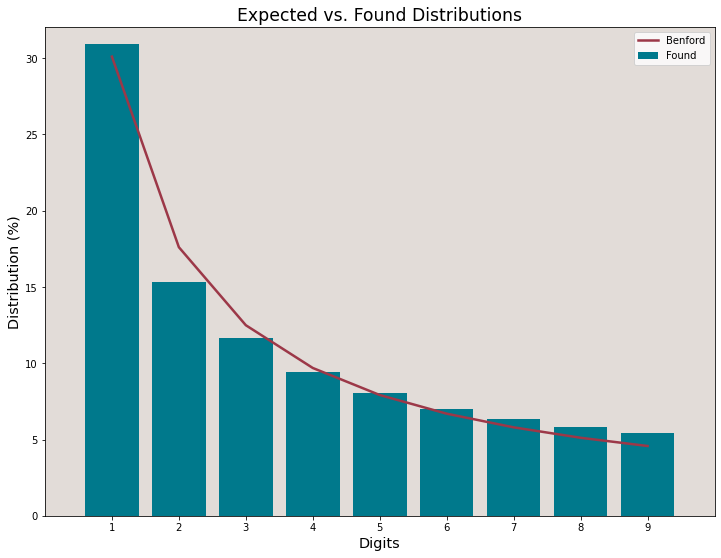

In [26]:
#create numpy array for speed
bf_dest_old = transcations.oldbalanceDest.sort_values().to_numpy() 
#calculate benford 
print('Old destination Balance')
benford_destinations_old =  bf.first_digits(bf_dest_old, digs=1, decimals='infer') # digs=1 for the first digit (1-9)

#Below the distribution looks good. 

New destination Balance

Initialized sequence with 7734831 registries.

Test performed on 7734831 registries.
Discarded 0 records < 1 after preparation.


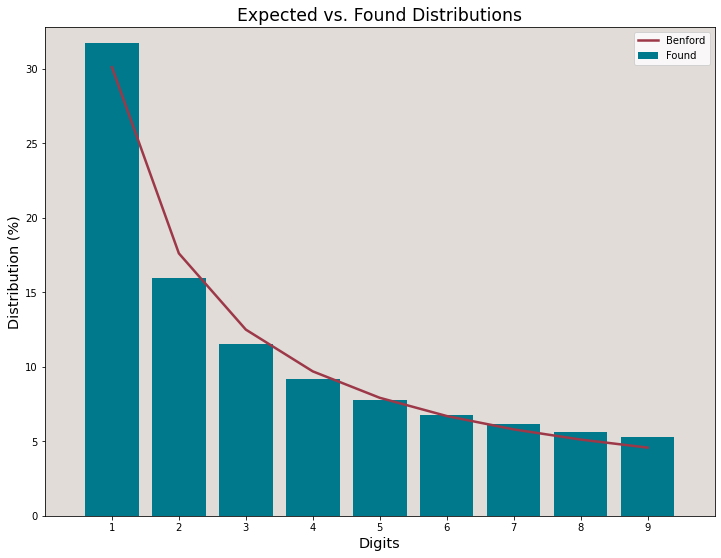

In [27]:
#create numpy array for speed
bf_dest_new = transcations.newbalanceDest.sort_values().to_numpy()
#calculate benford 
print('New destination Balance')
benford_destinations_new =  bf.first_digits(bf_dest_new, digs=1, decimals='infer') # digs=1 for the first digit (1-9)
#Below the distribution looks good 

Old origin Balance

Initialized sequence with 5182585 registries.

Test performed on 5182585 registries.
Discarded 0 records < 1 after preparation.


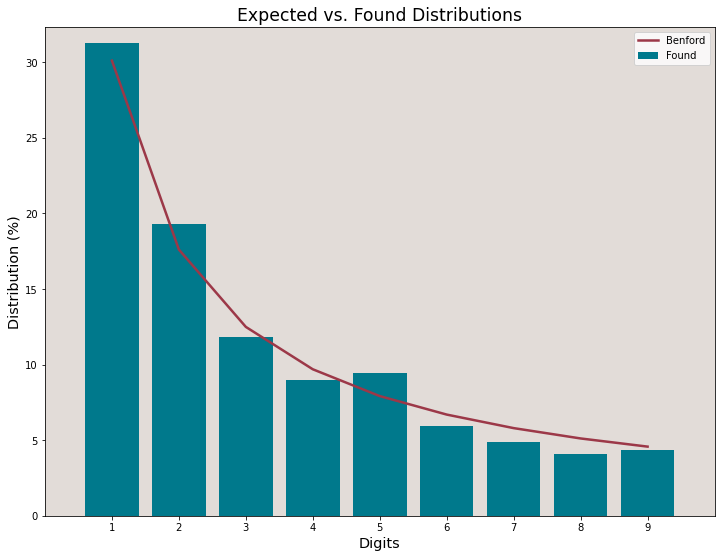

In [28]:
#create numpy array for speed
bf_orig_old = transcations.oldbalanceOrig.sort_values().to_numpy()
#calculate benford 
print('Old origin Balance')
benford_origin_old =  bf.first_digits(bf_orig_old, digs=1, decimals='infer') # digs=1 for the first digit (1-9)
#Distribution goes not look so good. Lots of ones, but more so 5's. Can check later.

new origin Balance

Initialized sequence with 7729347 registries.

Test performed on 7729347 registries.
Discarded 0 records < 1 after preparation.


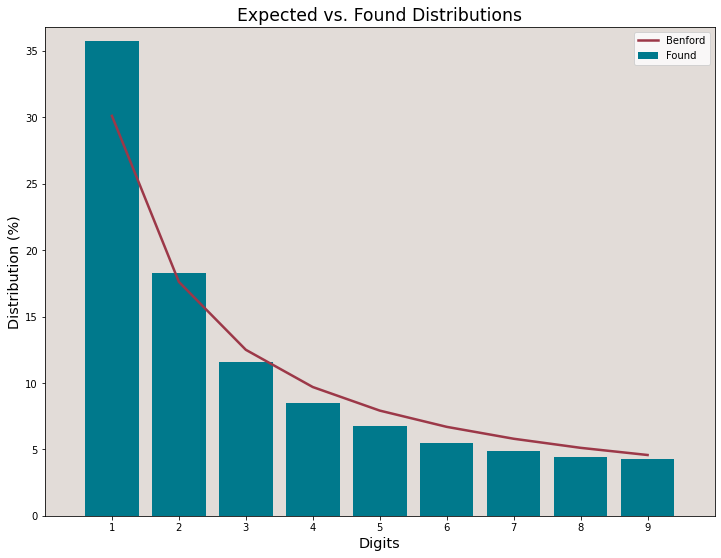

In [29]:
#create numpy array for speed
bf_orig_new = transcations.newbalanceOrig.sort_values().to_numpy()
#calculate benford 
print('new origin Balance')
benford_origin_new =  bf.first_digits(bf_orig_new, digs=1, decimals='infer') # digs=1 for the first digit (1-9)
#Distribution for new balances has more ones than usual. Should check.

### II. Data consistency check

Secondly, we check whether the data is consistent.This means that if an amount is transfered that there is no difference between the amount transfer and the difference of the old and new balance account between the originator and destination. 

#### II.A We check for precision before we begin any calculations

In [30]:
#First we check wheather transactions match. Where true means no difference and false indicates a difference.
abs(transcations.newbalanceOrig - transcations.oldbalanceOrig ) != transcations.amount

timestamp
1       True
1       True
1       True
1      False
1      False
       ...  
743     True
743    False
743    False
743     True
743     True
Length: 7734834, dtype: bool

In [31]:
#We check the first part of the calculation
abs(transcations.newbalanceOrig.iloc[0] - transcations.oldbalanceOrig.iloc[0])

0.010000000009313226

In [32]:
#We check the second part
transcations.amount.iloc[0]

0.01

II.A Conclusion:

First we see that the two don't match precisely but are considered the same by python. 
This could present a truncation error because of a floating point representation.

The same may occur if using integers because they use more memory which can also create an accumulated truncation after doing calcuations with 7 million rows of data. A nice solution to deal with this is the use of the Decimal Module.

#### II.B We check for differences

First we get the total amount of rows. Then we select columns to convert to numpy arrays (for fast calculations later). Then we create a dictionary (again for speed) to store the key (rows) and value (tuple of amount and new and old balance). Then we use an if then else condition to filter through negative balances while performing the calcuation. The calcuation per also converts data to string type to be used in an operation by the Decimal module (for precision to avoid floating point errors). 

In [33]:
rows = len(transcations) ; print(rows)

7734834


In [34]:
partions = 77 #we choose 77 so that each interval is ~100,000
schedule = [(round(i*rows/partions),round((i+1)*rows/partions)) for i in range(partions)]

schedule ; print(schedule[0:5],'...',schedule[-5:])

[(0, 100452), (100452, 200905), (200905, 301357), (301357, 401810), (401810, 502262)] ... [(7232572, 7333024), (7333024, 7433477), (7433477, 7533929), (7533929, 7634382), (7634382, 7734834)]


In [35]:
amount = transcations.amount.to_numpy() 

#create numpy arrays for Origin account
oldbalanceOrig = transcations.oldbalanceOrig.to_numpy() ; newbalanceOrig = transcations.newbalanceOrig.to_numpy()

#create numpy arrays for Destination account
oldbalanceDest = transcations.oldbalanceDest.to_numpy() ; newbalanceDest = transcations.newbalanceDest.to_numpy()

#Create dictionary...
difference_dict = { i : (amount[i] , oldbalanceOrig[i] , newbalanceOrig[i], oldbalanceDest[i], newbalanceDest[i]) for i in range(rows)} 

#shorthand for calcuations
d = difference_dict


In [36]:
# create a nested list comprehension with an if then else statement.
# we partion the calculations with the schedule as a nested loop which... 
# we acknowledge is a trade off between memory and calculation time  

difference = [[],[],[],[]] # we make four so that when j[0] is one or three the list is stored
                        # in element positions one and three of the list. 

# the tuple (3,4) refers to dictionary position of the destination balance, while..
# the tuple (1,2)... of the origin balance.
for j in [(1,2),(3,4)]:
    difference[j[0]] += [ ( abs( Decimal(str(d[i][j[1]])) - Decimal(str(d[i][j[0]])) ) - Decimal(str(d[i][0])) ) \
            if (  ( (d[i][j[1]] >= 0) & (d[i][j[0]] >= 0) ) or ( (d[i][j[1]] <= 0) & (d[i][j[0]] <= 0) )  ) \
            else ( abs( Decimal(str(d[i][j[1]])) - Decimal(str(d[i][j[0]])) ) - Decimal(str(d[i][0])) ) \
            for i in range(rows) ]


In [37]:
names = ['difference_Orig','difference_Dest'] ; _ = [1,3]

for k in range(2):
    transcations[names[k]] = difference[_[k]]
    print(transcations[names[k]][:10])

timestamp
1    0.00
1    0.00
1    0.00
1     0.0
1     0.0
1    0.01
1    0.00
1    0.00
1    0.00
1    0.01
Name: difference_Orig, dtype: object
timestamp
1     0.00
1    -0.01
1     0.00
1      0.0
1      0.0
1     0.00
1     0.00
1    -0.01
1     0.00
1     0.00
Name: difference_Dest, dtype: object


In [38]:
#we change the types to floats to plot.
transcations.difference_Dest = transcations.difference_Dest.astype('float64')
transcations.difference_Orig = transcations.difference_Orig.astype('float64')

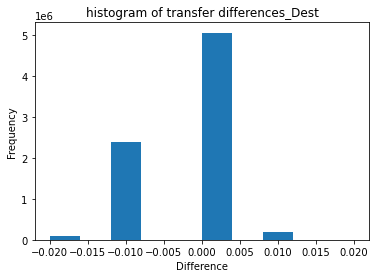

In [39]:
transcations.difference_Dest.plot.hist(title = 'histogram of transfer differences_Dest')
plt.xlabel('Difference')
plt.show()

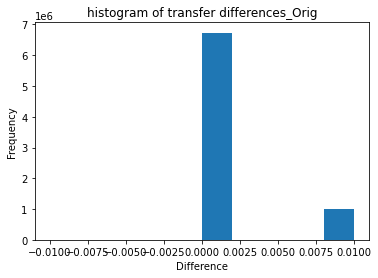

In [40]:
transcations.difference_Orig.plot.hist(title = 'histogram of transfer differences_Orig')
plt.xlabel('Difference')
plt.show()

So we have two classes of difference, one +/- 0.01 and another -0.02. We discard the  0.00's

#### II.B2 Now that we made difference columns, we can sum them to check whether differences occur.
* First we sum each differences column

In [41]:
#check type in dictionary
type(d[1][0])

numpy.float64

In [45]:

difference_orig_sum = Decimal('0.00')
dO = transcations.reset_index(drop=False).difference_Orig.to_dict()

for ii in range(rows):    
    difference_orig_sum = difference_orig_sum + Decimal(str(dO[ii]))
print('difference_orig_sum = ',difference_orig_sum)

difference_dest_sum = Decimal('0.00')
dD = transcations.reset_index(drop=False).difference_Dest.to_dict()

for ii in range(rows):    
    difference_dest_sum = difference_dest_sum + Decimal(str(dD[ii]))
print('difference_dest_sum =',difference_dest_sum)


difference_orig_sum =  10011.41
difference_dest_sum = -23718.04


In [46]:
print(f"Therefore the total difference is {difference_orig_sum + difference_dest_sum}")

Therefore the total difference is -13706.63


II.B Conclusion: There is a difference of +/- 0.01 cents for transactions on both the origin and destination accounts. In addition the sum of these show an imbalance of -13706.63 

# 4. Fraud Identification

According to the previous steps, negative account balances, inconsistencies for Benford's Law application (total amount, oldbalanceOrig and newbalancesOrig), and differences of 0.01 cents have been identified. These factors are checked in this section.

### I. First, we want to see which amount is most common to transfer.  

In [47]:
#We group by the amount. 
# We sort to see the most frequent amount transacted.
amount_frq = transcations.groupby(['amount']).type.count().sort_values()[::-1].reset_index().rename( columns={'type':'frequency'})
amount_frq[:15]

amount  frequency
0           0.010    1372195
1  10,000,000.000       3207
2      10,000.000         88
3       5,000.000         79
4      15,000.000         68
5         500.000         65
6     100,000.000         42
7      21,500.000         37
8     120,000.000         29
9     135,000.000         20
10          0.000         16
11      5,047.670          9
12        213.860          9
13      3,748.950          9
14      2,431.380          9

The first amount 0.01 is 1.3 million. It could be the outlier from benford's law.
The second amount (10 million) could be too. 

In [48]:
amount_frq.sort_values('amount').describe()

amount     frequency
count  5,316,909.000 5,316,909.000
mean     202,227.573         1.455
std      607,874.132       595.096
min            0.000         1.000
25%       22,695.050         1.000
50%      105,523.480         1.000
75%      235,419.910         1.000
max   92,445,516.640 1,372,195.000

Most transactions per a specified amount occur once with a std deviation of 595.
the 1.3 million is definitely an outlier.

In [49]:
amount_frq.drop(amount_frq.index[[0]]).describe()

amount     frequency
count  5,316,908.000 5,316,908.000
mean     202,227.612         1.197
std      607,874.183         1.492
min            0.000         1.000
25%       22,695.073         1.000
50%      105,523.550         1.000
75%      235,419.935         1.000
max   92,445,516.640     3,207.000

Removing the outlier already changes the std deviation significantly. 

In [50]:
amount_frq.drop(amount_frq.index[[0]]).drop(amount_frq.index[[1]]).describe()

amount     frequency
count  5,316,907.000 5,316,907.000
mean     202,225.769         1.196
std      607,859.389         0.542
min            0.000         1.000
25%       22,695.065         1.000
50%      105,523.480         1.000
75%      235,419.875         1.000
max   92,445,516.640        88.000

We still see the mean frequency is one and quintiles are also one. 
Below we check who receives an amount frequently. 

In [51]:
#We group by the destination name and amount. 
# We sort to see who recives an amount and count that times of transactions.
amount_account_frq = transcations.groupby(['nameDest','amount']).type.count().sort_values()[::-1]
amount_account_frq 

nameDest     amount        
C52983754    0.010             1372194
C1931758887  10,000,000.000          7
C1191573842  10,000,000.000          7
C440423148   10,000,000.000          6
C1062258222  10,000,000.000          6
                                ...   
M1028084099  31,564.030              1
M1028084303  2,471.510               1
M1028085950  2,209.980               1
M1028086925  11,577.450              1
C1000004082  23,297.190              1
Name: type, Length: 6361558, dtype: int64

In [52]:
#we save the name of the account that recieves many small transactions.
potential_fraud_id1 = amount_account_frq.index.droplevel(1)[0]
potential_fraud_id1

'C52983754'

In [53]:
#lets check
transcations[transcations.nameDest == potential_fraud_id1]
#many zero differences

type  amount     nameOrig  oldbalanceOrig  newbalanceOrig  \
timestamp                                                                  
1          TRANSFER   0.010  C1231006815     170,136.000     170,135.990   
1          TRANSFER   0.010    C90045638      53,860.000      53,859.990   
1          TRANSFER   0.010   C249177573      20,771.000      20,770.990   
1          TRANSFER   0.010  C1716932897      10,127.000      10,126.990   
1          TRANSFER   0.010   C761750706         450.000         449.990   
...             ...     ...          ...             ...             ...   
741        TRANSFER   0.010    C31496887     144,945.340     144,945.330   
742        TRANSFER   0.010  C1970706589   4,009,058.390   4,009,058.380   
742        TRANSFER   0.010  C1674778854      54,652.460      54,652.450   
742        TRANSFER   0.010  C1226129332     258,355.420     258,355.410   
743        TRANSFER   0.010  C1162922333   6,311,409.280   6,311,409.270   

            nameDest  oldbalanceDest  newbalanceDest  difference_Orig  \
timestamp                                                               
1          C52983754           0.010           0.020            0.000   
1          C52983754           0.020           0.030            0.000   
1          C52983754           0.030           0.040            0.000   
1          C52983754           0.040           0.050            0.000   
1          C52983754           0.050           0.060            0.000   
...              ...             ...             ...              ...   
741        C52983754      13,721.900      13,721.910            0.000   
742        C52983754      13,721.910      13,721.920            0.000   
742        C52983754      13,721.920      13,721.930            0.000   
742        C52983754      13,721.930      13,721.940            0.000   
743        C52983754      13,721.940      13,721.950            0.000   

           difference_Dest  
timestamp                   
1                    0.000  
1                    0.000  
1                    0.000  
1                    0.000  
1                    0.000  
...                    ...  
741                  0.000  
742                  0.000  
742                  0.000  
742                  0.000  
743                  0.000  

[1372194 rows x 10 columns]

In [54]:
transcations[transcations.nameOrig == potential_fraud_id1]

Empty DataFrame
Columns: [type, amount, nameOrig, oldbalanceOrig, newbalanceOrig, nameDest, oldbalanceDest, newbalanceDest, difference_Orig, difference_Dest]
Index: []

So the above account receives money but does not send.

In [55]:
cents = transcations[((transcations.difference_Orig != 0) | \
                      (transcations.difference_Dest != 0)) & \
                      (transcations.nameDest == potential_fraud_id1) ]

cents

type  amount     nameOrig  oldbalanceOrig  newbalanceOrig  \
timestamp                                                                  
17         TRANSFER   0.010  C1738972765      88,418.700      88,418.680   
18         TRANSFER   0.010  C1467095135    -259,356.170    -259,356.170   
22         TRANSFER   0.010   C553945398     -60,471.710     -60,471.710   
23         TRANSFER   0.010   C301090204     -57,860.790     -57,860.810   
35         TRANSFER   0.010    C34985720   3,914,767.770   3,914,767.770   
...             ...     ...          ...             ...             ...   
688        TRANSFER   0.010   C368484160       6,780.350       6,780.350   
690        TRANSFER   0.010   C469889917    -263,079.470    -263,079.470   
690        TRANSFER   0.010   C426467026    -123,971.960    -123,971.980   
710        TRANSFER   0.010  C1070681016    -147,862.580    -147,862.580   
710        TRANSFER   0.010  C1533871698  -2,631,038.880  -2,631,038.900   

            nameDest  oldbalanceDest  newbalanceDest  difference_Orig  \
timestamp                                                               
17         C52983754         794.010         794.020            0.010   
18         C52983754         912.280         912.290           -0.010   
22         C52983754       1,199.040       1,199.050           -0.010   
23         C52983754       1,227.990       1,228.000            0.010   
35         C52983754       1,410.750       1,410.760           -0.010   
...              ...             ...             ...              ...   
688        C52983754      13,643.430      13,643.440           -0.010   
690        C52983754      13,650.780      13,650.790           -0.010   
690        C52983754      13,658.210      13,658.220            0.010   
710        C52983754      13,708.280      13,708.290           -0.010   
710        C52983754      13,710.450      13,710.460            0.010   

           difference_Dest  
timestamp                   
17                   0.000  
18                   0.000  
22                   0.000  
23                   0.000  
35                   0.000  
...                    ...  
688                  0.000  
690                  0.000  
690                  0.000  
710                  0.000  
710                  0.000  

[382 rows x 10 columns]

In [56]:
cents.describe()

amount  oldbalanceOrig  newbalanceOrig  oldbalanceDest  newbalanceDest  \
count 382.000         382.000         382.000         382.000         382.000   
mean    0.010     911,851.456     911,851.447       9,211.662       9,211.672   
std     0.000   3,229,781.040   3,229,781.041       3,159.534       3,159.534   
min     0.010  -3,062,047.190  -3,062,047.190         794.010         794.020   
25%     0.010     -91,854.792     -91,854.807       6,849.622       6,849.632   
50%     0.010      -4,144.435      -4,144.455       9,789.730       9,789.740   
75%     0.010     166,867.408     166,867.387      11,858.070      11,858.080   
max     0.010  24,997,517.200  24,997,517.200      13,710.450      13,710.460   

       difference_Orig  difference_Dest  
count          382.000          382.000  
mean            -0.000            0.000  
std              0.010            0.000  
min             -0.010            0.000  
25%             -0.010            0.000  
50%             -0.010            0.000  
75%              0.010            0.000  
max              0.010            0.000

So it seems like there are only 382 rows where the difference is measureable. 
It seems like the 0.01 cent difference can be subtracted from the originators account,
and accumulated into the destinations account. The destination account has no negative difference, even if the originators difference is positive. 

In [57]:
transcations[ (transcations.difference_Dest != 0) & \
                      (transcations.nameDest == potential_fraud_id1) ]

Empty DataFrame
Columns: [type, amount, nameOrig, oldbalanceOrig, newbalanceOrig, nameDest, oldbalanceDest, newbalanceDest, difference_Orig, difference_Dest]
Index: []

In 382 transfers, was there a difference of more than 0 to the potential fraud account. Yet in 1372194 transfer of said account, there was no measureable difference, only a transfer of 0.01 cents. This may mean that there is no fraud going on and only multiple accounts transfer a small fee towards this account. One might think it is strange the that account only receives money. Maybe. It could be a confirmation account for new users of xyz product or business. It could also actually be fraud but we do not know. We would have to confirm whether the accounts meant to send 0.01. 

Additionally, we can check whether more than 1.3 million people sent a transaction of 0.01 to others. and also whether an account send money frequently. 

In [58]:
transcations[((transcations.amount > 0.0001) & (transcations.amount < .02)) & (transcations.nameDest != potential_fraud_id1) ]

type  amount     nameOrig  oldbalanceOrig  newbalanceOrig  \
timestamp                                                                  
332        TRANSFER   0.010  C1496340830           0.000          -0.010   

             nameDest  oldbalanceDest  newbalanceDest  difference_Orig  \
timestamp                                                                
332        C554562342     262,792.780     262,792.790            0.000   

           difference_Dest  
timestamp                   
332                  0.000

We conclude no body else sends 0.01. But lets check who else has sent money to this account.

In [59]:
transcations[transcations.nameDest == 'C554562342']

type      amount     nameOrig  oldbalanceOrig  newbalanceOrig  \
timestamp                                                                      
321        TRANSFER 202,870.940   C755410383      24,901.000    -177,969.950   
325        TRANSFER  59,921.850   C109555795           0.000     -59,921.850   
332        TRANSFER       0.010  C1496340830           0.000          -0.010   
375        TRANSFER  71,346.130  C1481195031           0.000     -71,346.130   
546        TRANSFER  26,251.990   C682791149      31,125.000       4,873.010   

             nameDest  oldbalanceDest  newbalanceDest  difference_Orig  \
timestamp                                                                
321        C554562342           0.000     202,870.930            0.010   
325        C554562342     202,870.930     262,792.780            0.000   
332        C554562342     262,792.780     262,792.790            0.000   
375        C554562342     262,792.790     334,138.920            0.000   
546        C554562342     334,138.920     360,390.910            0.000   

           difference_Dest  
timestamp                   
321                 -0.010  
325                  0.000  
332                  0.000  
375                  0.000  
546                  0.000

This could potentially be another fraud account as the people who transfer money have their accounts relatively drained to zero or close. Let check if this account has sent money.

In [60]:
transcations[transcations.nameOrig == 'C554562342']

Empty DataFrame
Columns: [type, amount, nameOrig, oldbalanceOrig, newbalanceOrig, nameDest, oldbalanceDest, newbalanceDest, difference_Orig, difference_Dest]
Index: []

It has not. We conclude that this account has made roughly 13.

### I.B We check negative account balances
 First, we check for old negative balances on originating accounts. Second, we check for zero balances on originating accounts. Third, we check for new negative balances on originating accounts.


In [61]:
#checking each name destination that took money from a negative initial accountbalance
#  shows a systematic accumulation of wealth into destinators account. There are about 7,000 names
negative_oldbalance_orig = transcations[transcations.oldbalanceOrig < 0]

f= 4
transcations[transcations.nameDest == negative_oldbalance_orig.nameDest.iloc[f]]

type        amount     nameOrig  oldbalanceOrig  \
timestamp                                                        
14         TRANSFER    65,072.010   C779875094     -31,395.750   
15         TRANSFER   676,690.530   C617028201         484.000   
16         TRANSFER   115,091.960  C2121507747      71,662.000   
16         TRANSFER   110,773.770   C166793160           0.000   
19         TRANSFER   214,024.140  C1920914752   8,792,342.740   
20         TRANSFER   208,641.690   C433552606      29,803.000   
20         TRANSFER    28,534.660  C1690859257     107,465.410   
20         TRANSFER   292,445.580   C179211082           0.000   
21         TRANSFER     6,934.990  C1954033936   1,065,723.050   
36         TRANSFER    26,922.060   C970620836   8,322,679.050   
38         TRANSFER   441,924.380   C999513843       1,059.000   
39         TRANSFER   189,906.470   C966985024   4,036,559.230   
40         TRANSFER   186,906.280   C596075971           0.000   
42         TRANSFER    88,438.430  C1284258156  17,414,313.850   
131        TRANSFER     5,138.770  C1504258542           0.000   
136        TRANSFER    39,571.900   C761322767   7,379,502.100   
138        TRANSFER    88,922.530  C1220097274     599,346.750   
154        TRANSFER   324,886.600   C739295038           0.000   
161        TRANSFER   217,054.790  C2021490665     200,915.000   
186        TRANSFER   139,894.370   C418270737       3,556.000   
210        TRANSFER   863,911.640   C144368530           0.000   
229        TRANSFER   330,505.680    C38072408           0.000   
237        TRANSFER   158,202.090  C1284927670      51,602.000   
257        TRANSFER   246,608.870   C185935818      11,495.000   
259        TRANSFER    71,509.600   C971226063           0.000   
259        TRANSFER   330,076.830   C818495478   3,689,094.290   
302        TRANSFER 2,253,423.690  C1914773551           0.000   
304        TRANSFER   152,749.330   C675714029   4,818,930.630   
309        TRANSFER    61,422.080  C1545269179           0.000   
346        TRANSFER   418,765.060    C47051903           0.000   
380        TRANSFER    83,765.260  C2105710603  13,912,074.650   
407        TRANSFER 1,260,307.320   C846511119      45,363.620   
469        TRANSFER   116,114.220  C1865021609      52,551.000   

           newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  \
timestamp                                                                
14            -96,467.760  C1513231255     106,963.000     172,035.010   
15           -676,206.530  C1513231255     172,035.010     848,725.540   
16            -43,429.960  C1513231255     848,725.540     963,817.490   
16           -110,773.770  C1513231255     963,817.490   1,074,591.260   
19          8,578,318.600  C1513231255   1,074,591.260   1,288,615.400   
20           -178,838.690  C1513231255   1,288,615.400   1,497,257.080   
20             78,930.750  C1513231255   1,497,257.080   1,525,791.740   
20           -292,445.580  C1513231255   1,525,791.740   1,818,237.310   
21          1,058,788.060  C1513231255   1,818,237.310   1,825,172.300   
36          8,295,756.990  C1513231255   1,825,172.300   1,852,094.360   
38           -440,865.380  C1513231255   1,852,094.360   2,294,018.750   
39          3,846,652.750  C1513231255   2,294,018.750   2,483,925.210   
40           -186,906.280  C1513231255   2,483,925.210   2,670,831.490   
42         17,325,875.420  C1513231255   2,670,831.490   2,759,269.920   
131            -5,138.770  C1513231255   2,759,269.920   2,764,408.690   
136         7,339,930.200  C1513231255   2,764,408.690   2,803,980.590   
138           510,424.220  C1513231255   2,803,980.590   2,892,903.120   
154          -324,886.600  C1513231255   2,892,903.120   3,217,789.720   
161           -16,139.790  C1513231255   3,217,789.720   3,434,844.510   
186          -136,338.370  C1513231255   3,434,844.510   3,574,738.870   
210          -863,911.640  C1513231255   3,574,738.870   4,438,650.510   
22

In [62]:
potential_fraud_df = transcations[transcations.oldbalanceOrig < 0].groupby('nameDest').count().type.sort_values()[::-1]
potential_fraud_df

nameDest
C52983754      1277
C369411086        2
C621989653        2
C811379973        2
C974625791        2
               ... 
M107469699        1
M1076209428       1
M1076777255       1
M1077060483       1
C1000185448       1
Name: type, Length: 5949, dtype: int64

We see that accounts in this class only receive money from a negative account balance twice or once, but further checks shows most of these accounts balances gain over a million by the end of the timestamp. Most do not send money either.

In [63]:
#try 1, 2,3, 100, 1000, 5948
ff = 1000
potential_fraud_id2 = potential_fraud_df.index[ff]
transcations[transcations.nameDest == potential_fraud_id2]

type        amount     nameOrig  oldbalanceOrig  \
timestamp                                                        
133        TRANSFER    32,813.670  C1616733372      10,382.000   
179        TRANSFER   224,814.510  C2138887017     273,613.000   
234        TRANSFER   229,623.780  C1408242117      11,111.000   
259        TRANSFER   162,265.720   C949972542     289,590.850   
282        TRANSFER    42,401.770  C1362536894      45,499.760   
349        TRANSFER   416,253.470  C1328742569           0.000   
353        TRANSFER 3,569,605.520   C161143347      51,956.000   
372        TRANSFER    83,317.960   C462636694      -7,498.940   
397        TRANSFER   151,488.370   C503274551           0.000   
525        TRANSFER   292,631.410  C2022281678           0.000   
542        TRANSFER   271,562.240   C593638840   3,279,387.300   

           newbalanceOrig    nameDest  oldbalanceDest  newbalanceDest  \
timestamp                                                               
133           -22,431.670  C539728191      38,287.000      71,100.670   
179            48,798.490  C539728191      71,100.670     295,915.180   
234          -218,512.780  C539728191     295,915.180     525,538.950   
259           127,325.120  C539728191     525,538.950     687,804.670   
282             3,097.990  C539728191     687,804.670     730,206.440   
349          -416,253.470  C539728191     730,206.440   1,146,459.900   
353        -3,517,649.520  C539728191   1,146,459.900   4,716,065.410   
372           -90,816.900  C539728191   4,716,065.410   4,799,383.370   
397          -151,488.370  C539728191   4,799,383.370   4,950,871.740   
525          -292,631.410  C539728191   4,950,871.740   5,243,503.140   
542         3,007,825.060  C539728191   5,243,503.140   5,515,065.380   

           difference_Orig  difference_Dest  
timestamp                                    
133                  0.000            0.000  
179                  0.000            0.000  
234                  0.000           -0.010  
259                  0.010            0.000  
282                  0.000            0.000  
349                  0.000           -0.010  
353                  0.000           -0.010  
372                  0.000            0.000  
397                  0.000            0.000  
525                  0.000           -0.010  
542                  0.000            0.000

In [64]:
transcations[transcations.nameOrig == potential_fraud_id2]

Empty DataFrame
Columns: [type, amount, nameOrig, oldbalanceOrig, newbalanceOrig, nameDest, oldbalanceDest, newbalanceDest, difference_Orig, difference_Dest]
Index: []

### I.C We check for new zero balances on originating accounts

In [65]:
zero_newbalance_orig = transcations[transcations.newbalanceOrig == 0]
zero_newbalance_orig

type        amount     nameOrig  oldbalanceOrig  \
timestamp                                                        
1          TRANSFER       181.000  C1305486145         181.000   
1          TRANSFER       181.000   C840083671         181.000   
1          TRANSFER     2,806.000  C1420196421       2,806.000   
1          TRANSFER     2,806.000  C2101527076       2,806.000   
1          TRANSFER    20,128.000  C1118430673      20,128.000   
...             ...           ...          ...             ...   
743        TRANSFER 1,258,818.820  C1531301470   1,258,818.820   
743        TRANSFER 1,258,818.820  C1436118706   1,258,818.820   
743        TRANSFER 6,311,409.280  C1529008245   6,311,409.280   
743        TRANSFER 6,311,409.280  C1162922333   6,311,409.280   
743        TRANSFER   850,002.520  C1685995037     850,002.520   

           newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  \
timestamp                                                                
1                   0.000   C553264065           0.000         181.000   
1                   0.000    C38997010      21,182.000      21,363.000   
1                   0.000   C972765878           0.000       2,806.000   
1                   0.000  C1007251739      26,202.000      29,007.990   
1                   0.000   C339924917       6,268.000      26,395.990   
...                   ...          ...             ...             ...   
743                 0.000  C1470998563           0.000   1,258,818.820   
743                 0.000  C1240760502   1,404,436.350   2,663,255.170   
743                 0.000  C1881841831           0.000   6,311,409.280   
743                 0.000  C1365125890     351,848.640   6,663,257.910   
743                 0.000  C2080388513           0.000     850,002.520   

           difference_Orig  difference_Dest  
timestamp                                    
1                    0.000            0.000  
1                    0.000            0.000  
1                    0.000            0.000  
1                    0.000           -0.010  
1                    0.000           -0.010  
...                    ...              ...  
743                  0.000            0.000  
743                  0.000            0.000  
743                  0.000            0.000  
743                  0.000           -0.010  
743                  0.000            0.000  

[5487 rows x 10 columns]

In [66]:
transcations[transcations.nameDest == 'C1881841831'	]

type        amount     nameOrig  oldbalanceOrig  \
timestamp                                                        
743        TRANSFER 6,311,409.280  C1529008245   6,311,409.280   

           newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  \
timestamp                                                                
743                 0.000  C1881841831           0.000   6,311,409.280   

           difference_Orig  difference_Dest  
timestamp                                    
743                  0.000            0.000

In [67]:
transcations[transcations.nameDest == 'C1365125890'	]

type        amount     nameOrig  oldbalanceOrig  \
timestamp                                                        
206        TRANSFER   257,514.800   C108974330         313.000   
254        TRANSFER    68,488.840   C342732184     139,296.000   
743        TRANSFER 6,311,409.280  C1162922333   6,311,409.280   

           newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  \
timestamp                                                                
206          -257,201.800  C1365125890      25,845.000     283,359.790   
254            70,807.160  C1365125890     283,359.790     351,848.640   
743                 0.000  C1365125890     351,848.640   6,663,257.910   

           difference_Orig  difference_Dest  
timestamp                                    
206                  0.000           -0.010  
254                  0.000            0.010  
743                  0.000           -0.010

In [68]:
zero_newbalance_orig.nameDest.isin(negative_oldbalance_orig.nameDest).sum()

36

36 have people whose accounts went to zero also transfered the destinations that took negative money from people

In [69]:
zero_newbalance_orig.nameOrig.isin(negative_oldbalance_orig.nameOrig).sum()

0

In [70]:
zero_newbalance = transcations[(transcations.newbalanceOrig == 0) & (transcations.oldbalanceDest == 0)]
zero_newbalance

type        amount     nameOrig  oldbalanceOrig  \
timestamp                                                        
1          TRANSFER       181.000  C1305486145         181.000   
1          TRANSFER     2,806.000  C1420196421       2,806.000   
1          TRANSFER 1,277,212.770   C467632528   1,277,212.770   
2          TRANSFER    14,949.840   C140702728      14,949.840   
3          TRANSFER    10,539.370  C1134864869      10,539.370   
...             ...           ...          ...             ...   
742        TRANSFER   258,355.420  C1226129332     258,355.420   
742        TRANSFER    63,416.990   C778071008      63,416.990   
743        TRANSFER 1,258,818.820  C1531301470   1,258,818.820   
743        TRANSFER 6,311,409.280  C1529008245   6,311,409.280   
743        TRANSFER   850,002.520  C1685995037     850,002.520   

           newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  \
timestamp                                                                
1                   0.000   C553264065           0.000         181.000   
1                   0.000   C972765878           0.000       2,806.000   
1                   0.000   C716083600           0.000   1,277,212.760   
2                   0.000   C634210724           0.000      14,949.830   
3                   0.000   C118648358           0.000      10,539.370   
...                   ...          ...             ...             ...   
742                 0.000  C1744173808           0.000     258,355.410   
742                 0.000  C1812552860           0.000      63,416.990   
743                 0.000  C1470998563           0.000   1,258,818.820   
743                 0.000  C1881841831           0.000   6,311,409.280   
743                 0.000  C2080388513           0.000     850,002.520   

           difference_Orig  difference_Dest  
timestamp                                    
1                    0.000            0.000  
1                    0.000            0.000  
1                    0.000           -0.010  
2                    0.000           -0.010  
3                    0.000            0.000  
...                    ...              ...  
742                  0.000           -0.010  
742                  0.000            0.000  
743                  0.000            0.000  
743                  0.000            0.000  
743                  0.000            0.000  

[3248 rows x 10 columns]

In [71]:
len(zero_newbalance.nameDest.unique())

3248

In [72]:
transcations[transcations.nameDest == 'C2080388513']

type      amount     nameOrig  oldbalanceOrig  newbalanceOrig  \
timestamp                                                                      
743        TRANSFER 850,002.520  C1685995037     850,002.520           0.000   

              nameDest  oldbalanceDest  newbalanceDest  difference_Orig  \
timestamp                                                                 
743        C2080388513           0.000     850,002.520            0.000   

           difference_Dest  
timestamp                   
743                  0.000

### I.D We check for new negative values on account balances or originators

In [73]:
transcations[transcations.newbalanceOrig < 0]

type      amount     nameOrig  oldbalanceOrig  newbalanceOrig  \
timestamp                                                                      
1          TRANSFER   4,024.360  C1265012928       2,671.000      -1,353.360   
1          TRANSFER   9,644.940  C1900366749       4,465.000      -5,179.940   
1          TRANSFER  11,633.760  C1716932897      10,127.000      -1,506.760   
1          TRANSFER 229,133.940   C905080434      15,325.000    -213,808.940   
1          TRANSFER   1,563.820   C761750706         450.000      -1,113.820   
...             ...         ...          ...             ...             ...   
742        TRANSFER 303,846.740  C1148860488     303,846.740          -0.010   
742        TRANSFER  63,416.990   C994950684      63,416.990          -0.010   
743        TRANSFER 339,682.130  C2013999242     339,682.130          -0.010   
743        TRANSFER 339,682.130   C786484425     339,682.130          -0.010   
743        TRANSFER 850,002.520  C1280323807     850,002.520          -0.010   

              nameDest  oldbalanceDest  newbalanceDest  difference_Orig  \
timestamp                                                                 
1          M1176932104           0.000       4,024.360            0.000   
1           C997608398      10,845.000      20,489.940            0.000   
1           M801569151           0.000      11,633.750            0.000   
1           C476402209       5,083.000     234,216.940            0.000   
1          M1731217984           0.000       1,563.810            0.000   
...                ...             ...             ...              ...   
742         C846260566     343,660.880     647,507.610            0.010   
742        C1662241365     438,545.220     501,962.200            0.010   
743        C1850423904           0.000     339,682.120            0.010   
743         C776919290     382,920.110     722,602.230            0.010   
743         C873221189   8,150,751.040   9,000,753.550            0.010   

           difference_Dest  
timestamp                   
1                    0.000  
1                    0.000  
1                   -0.010  
1                    0.000  
1                   -0.010  
...                    ...  
742                 -0.010  
742                 -0.010  
743                 -0.010  
743                 -0.010  
743                 -0.010  

[4536677 rows x 10 columns]

In [74]:
#lets filter 0.01 out.
negative_newbalanceOrig = transcations[(transcations.newbalanceOrig < 0) & (transcations.amount != 0.01) ]
negative_newbalanceOrig
#eliminated 500,000 

type      amount     nameOrig  oldbalanceOrig  newbalanceOrig  \
timestamp                                                                      
1          TRANSFER   4,024.360  C1265012928       2,671.000      -1,353.360   
1          TRANSFER   9,644.940  C1900366749       4,465.000      -5,179.940   
1          TRANSFER  11,633.760  C1716932897      10,127.000      -1,506.760   
1          TRANSFER 229,133.940   C905080434      15,325.000    -213,808.940   
1          TRANSFER   1,563.820   C761750706         450.000      -1,113.820   
...             ...         ...          ...             ...             ...   
742        TRANSFER 303,846.740  C1148860488     303,846.740          -0.010   
742        TRANSFER  63,416.990   C994950684      63,416.990          -0.010   
743        TRANSFER 339,682.130  C2013999242     339,682.130          -0.010   
743        TRANSFER 339,682.130   C786484425     339,682.130          -0.010   
743        TRANSFER 850,002.520  C1280323807     850,002.520          -0.010   

              nameDest  oldbalanceDest  newbalanceDest  difference_Orig  \
timestamp                                                                 
1          M1176932104           0.000       4,024.360            0.000   
1           C997608398      10,845.000      20,489.940            0.000   
1           M801569151           0.000      11,633.750            0.000   
1           C476402209       5,083.000     234,216.940            0.000   
1          M1731217984           0.000       1,563.810            0.000   
...                ...             ...             ...              ...   
742         C846260566     343,660.880     647,507.610            0.010   
742        C1662241365     438,545.220     501,962.200            0.010   
743        C1850423904           0.000     339,682.120            0.010   
743         C776919290     382,920.110     722,602.230            0.010   
743         C873221189   8,150,751.040   9,000,753.550            0.010   

           difference_Dest  
timestamp                   
1                    0.000  
1                    0.000  
1                   -0.010  
1                    0.000  
1                   -0.010  
...                    ...  
742                 -0.010  
742                 -0.010  
743                 -0.010  
743                 -0.010  
743                 -0.010  

[4082254 rows x 10 columns]

In [75]:
negative_newbalanceOrig.describe()

amount  oldbalanceOrig  newbalanceOrig  oldbalanceDest  \
count  4,082,254.000   4,082,254.000   4,082,254.000   4,082,254.000   
mean     234,529.106      17,528.949    -217,000.159   1,721,005.270   
std      735,932.005      84,574.220     731,182.179   3,971,349.370   
min            0.000 -46,211,920.920 -92,445,516.640  -4,366,622.920   
25%       23,308.885           0.000    -229,404.215           0.000   
50%      117,369.325           0.000     -95,519.860     433,847.350   
75%      254,523.527      14,552.000     -18,028.155   1,947,128.292   
max   92,445,516.640  10,000,000.000          -0.010 357,277,441.820   

       newbalanceDest  difference_Orig  difference_Dest  
count   4,082,254.000    4,082,254.000    4,082,254.000  
mean    1,955,534.372            0.002           -0.004  
std     4,263,711.249            0.004            0.006  
min    -4,234,680.130           -0.010           -0.020  
25%        34,511.803            0.000           -0.010  
50%       661,485.225            0.000            0.000  
75%     2,246,871.587            0.000            0.000  
max   357,440,831.380            0.010            0.010

In [76]:
negative_newbalanceOrig_frq = negative_newbalanceOrig.groupby('nameDest').count().amount.sort_values()[::-1]
negative_newbalanceOrig_frq

nameDest
C665576141     74
C1286084959    73
C1789550256    67
C97730845      67
C2006081398    65
               ..
M1973531802     1
M197353342      1
M1973535773     1
M1973536508     1
M1494486771     1
Name: amount, Length: 1638597, dtype: int64

In [77]:
transcations[transcations.nameDest == negative_newbalanceOrig_frq.index[0]][:10]

type        amount     nameOrig  oldbalanceOrig  \
timestamp                                                        
1          TRANSFER 1,505,626.010   C926859124           0.000   
1          TRANSFER     3,428.950  C1317375498     147,798.000   
1          TRANSFER 1,349,670.680  C1419332030           0.000   
1          TRANSFER   156,922.360  C1706272858   1,281,862.280   
1          TRANSFER   106,727.810   C865858182   4,927,051.900   
1          TRANSFER   352,568.350  C1256405521       9,945.000   
1          TRANSFER 1,867,849.020   C355885103           0.000   
1          TRANSFER 1,201,716.660   C695248316           0.000   
1          TRANSFER   315,325.250  C1048128739           0.000   
1          TRANSFER    33,499.160  C2050320909   5,664,660.650   

           newbalanceOrig    nameDest  oldbalanceDest  newbalanceDest  \
timestamp                                                               
1          -1,505,626.010  C665576141      29,031.000   1,534,657.000   
1             144,369.050  C665576141   1,534,657.000   1,538,085.950   
1          -1,349,670.690  C665576141   1,538,085.950   2,887,756.620   
1           1,124,939.920  C665576141   2,887,756.620   3,044,678.980   
1           4,820,324.090  C665576141   3,044,678.980   3,151,406.790   
1            -342,623.350  C665576141   3,151,406.790   3,503,975.140   
1          -1,867,849.020  C665576141   3,503,975.140   5,371,824.160   
1          -1,201,716.670  C665576141   5,371,824.160   6,573,540.820   
1            -315,325.260  C665576141   6,573,540.820   6,888,866.060   
1           5,631,161.490  C665576141   6,888,866.060   6,922,365.210   

           difference_Orig  difference_Dest  
timestamp                                    
1                    0.000           -0.010  
1                    0.000            0.000  
1                    0.010           -0.010  
1                    0.000            0.000  
1                    0.000            0.000  
1                    0.000            0.000  
1                    0.000            0.000  
1                    0.010            0.000  
1                    0.010           -0.010  
1                    0.000           -0.010

In [78]:
transcations[transcations.nameOrig == negative_newbalanceOrig_frq.index[0]][:10]

Empty DataFrame
Columns: [type, amount, nameOrig, oldbalanceOrig, newbalanceOrig, nameDest, oldbalanceDest, newbalanceDest, difference_Orig, difference_Dest]
Index: []

One in the first timestamp, this account drained... at least five other accounts into negative. 

In [79]:
transcations[transcations.nameDest == negative_newbalanceOrig_frq.index[0]].nameDest.isin(zero_newbalance_orig.nameDest).sum()

0

So this class of accounts is also rich with accounts transferring money in, but has
no overlap with the zero_newbalance_orig or negative_oldbalance_Orig class accounts. 

### II.A We check the 10 million transfers as there are 3702

In [80]:
ten_million = transcations[transcations.amount == 10000000]


print('orginators',len(ten_million.nameOrig.unique()))
print('destination',len(ten_million.nameDest.unique()))

ten_million
#We already saw that there are a few who recive 10 million 5 to 7 times.
#But it is odd to see a transfer in which the account has an exact balance of 10 million 
# before the transaction and zero after.

orginators 3207
destination 2124


type         amount     nameOrig  oldbalanceOrig  \
timestamp                                                         
4          TRANSFER 10,000,000.000     C7162498  12,930,418.440   
4          TRANSFER 10,000,000.000   C351297720  10,000,000.000   
19         TRANSFER 10,000,000.000   C416779475  11,861,008.320   
19         TRANSFER 10,000,000.000  C2050703310  10,000,000.000   
33         TRANSFER 10,000,000.000  C1439740840  19,887,819.060   
...             ...            ...          ...             ...   
741        TRANSFER 10,000,000.000  C1647199421  10,000,000.000   
741        TRANSFER 10,000,000.000    C88849251  25,674,547.890   
741        TRANSFER 10,000,000.000   C677394894  10,000,000.000   
741        TRANSFER 10,000,000.000  C1945606464  15,674,547.890   
741        TRANSFER 10,000,000.000  C1668034607  10,000,000.000   

           newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  \
timestamp                                                                
4           2,930,418.440   C945327594           0.000   9,999,999.990   
4                   0.000   C766681183           0.000  10,000,000.000   
19          1,861,008.310   C380259496           0.000   9,999,999.990   
19                  0.000  C1622860679     611,207.400  10,611,207.390   
33          9,887,819.060   C875288652           0.000  10,000,000.000   
...                   ...          ...             ...             ...   
741                -0.010  C2077145577     291,708.640  10,291,708.630   
741        15,674,547.890  C1939028448           0.000   9,999,999.990   
741                 0.000  C1866259073           0.000  10,000,000.000   
741         5,674,547.890   C625944676           0.000  10,000,000.000   
741                 0.000  C1250722530     192,912.980  10,192,912.970   

           difference_Orig  difference_Dest  
timestamp                                    
4                    0.000           -0.010  
4                    0.000            0.000  
19                   0.010           -0.010  
19                   0.000           -0.010  
33                   0.000            0.000  
...                    ...              ...  
741                  0.010           -0.010  
741                  0.000           -0.010  
741                  0.000            0.000  
741                  0.000            0.000  
741                  0.000           -0.010  

[3207 rows x 10 columns]

In [81]:
ten_million[ten_million.oldbalanceOrig == 10000000]

type         amount     nameOrig  oldbalanceOrig  \
timestamp                                                         
4          TRANSFER 10,000,000.000   C351297720  10,000,000.000   
19         TRANSFER 10,000,000.000  C2050703310  10,000,000.000   
33         TRANSFER 10,000,000.000    C29118015  10,000,000.000   
72         TRANSFER 10,000,000.000  C1438388258  10,000,000.000   
82         TRANSFER 10,000,000.000  C1079335762  10,000,000.000   
...             ...            ...          ...             ...   
736        TRANSFER 10,000,000.000  C1842402025  10,000,000.000   
741        TRANSFER 10,000,000.000   C421958672  10,000,000.000   
741        TRANSFER 10,000,000.000  C1647199421  10,000,000.000   
741        TRANSFER 10,000,000.000   C677394894  10,000,000.000   
741        TRANSFER 10,000,000.000  C1668034607  10,000,000.000   

           newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  \
timestamp                                                                
4                   0.000   C766681183           0.000  10,000,000.000   
19                  0.000  C1622860679     611,207.400  10,611,207.390   
33                  0.000  C1379703840           0.000  10,000,000.000   
72                 -0.010  C1089455271      81,810.400  10,081,810.400   
82                  0.000   C615227407   1,224,264.090  11,224,264.100   
...                   ...          ...             ...             ...   
736                 0.000  C1291939349           0.000   9,999,999.990   
741                -0.010  C2034016962           0.000   9,999,999.990   
741                -0.010  C2077145577     291,708.640  10,291,708.630   
741                 0.000  C1866259073           0.000  10,000,000.000   
741                 0.000  C1250722530     192,912.980  10,192,912.970   

           difference_Orig  difference_Dest  
timestamp                                    
4                    0.000            0.000  
19                   0.000           -0.010  
33                   0.000            0.000  
72                   0.010            0.000  
82                   0.000            0.010  
...                    ...              ...  
736                  0.000           -0.010  
741                  0.010           -0.010  
741                  0.010           -0.010  
741                  0.000            0.000  
741                  0.000           -0.010  

[142 rows x 10 columns]

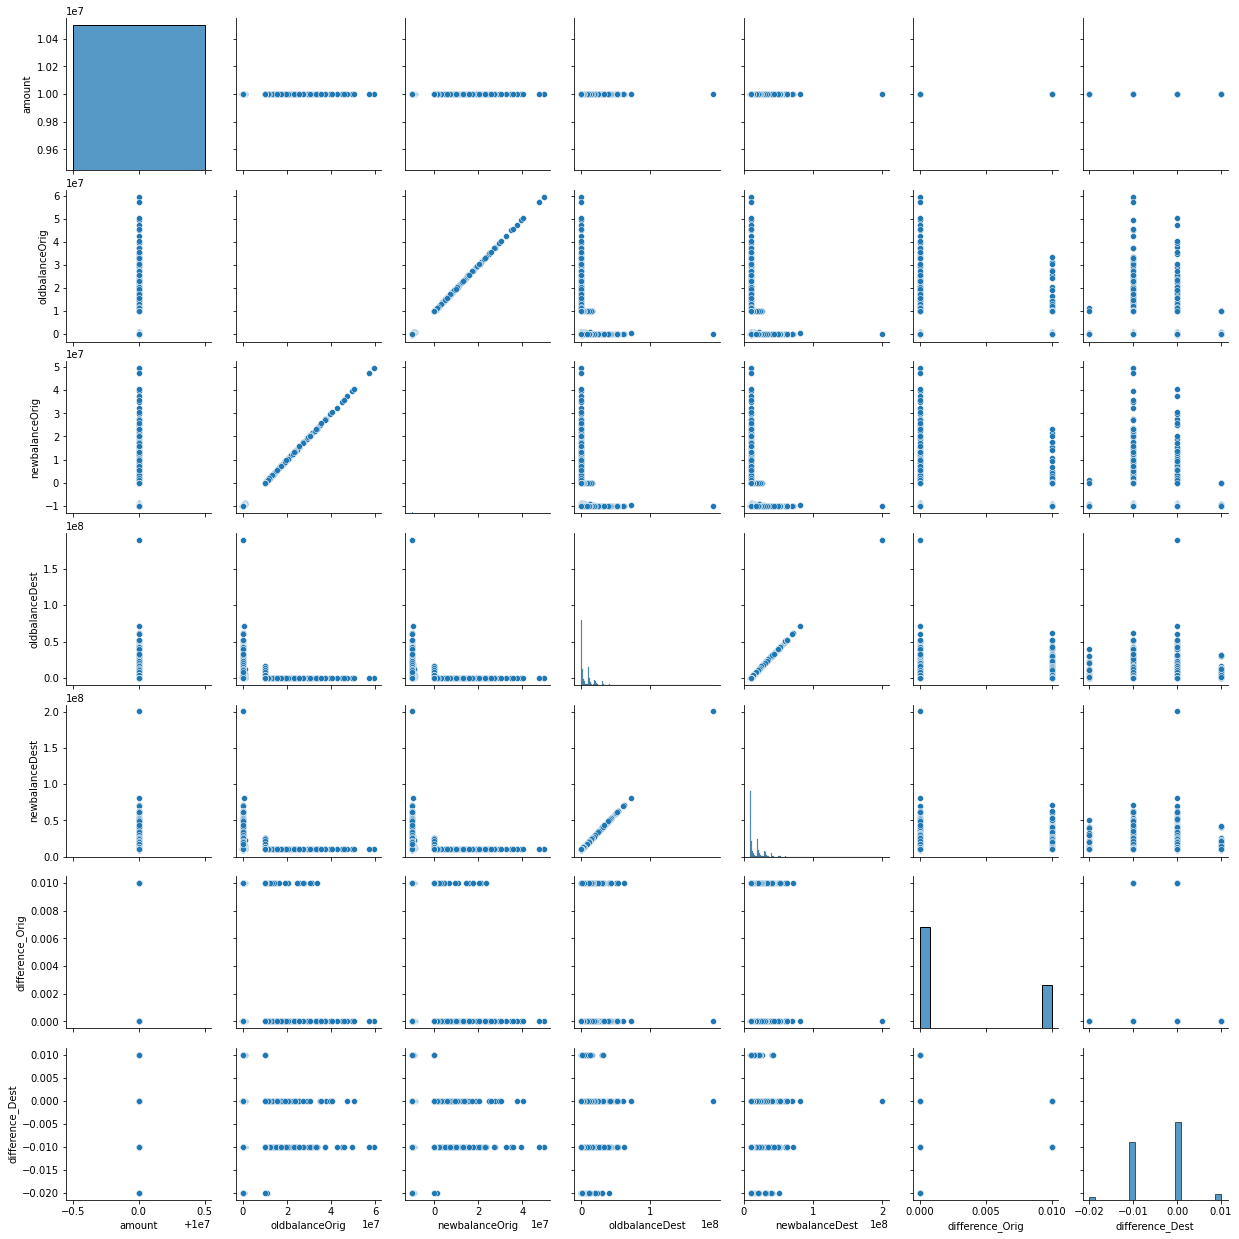

In [90]:
sns.pairplot(ten_million)
#There are linear relationships within the data that we would expect, like old and new balances for either a origin or destination account. 

In [83]:
df_potential_fraud_df2 = ten_million[(ten_million.oldbalanceOrig == 10000000) & ((ten_million.newbalanceOrig == 0) | (ten_million.newbalanceOrig == -.01)) ]
df_potential_fraud_df2


type         amount     nameOrig  oldbalanceOrig  \
timestamp                                                         
4          TRANSFER 10,000,000.000   C351297720  10,000,000.000   
19         TRANSFER 10,000,000.000  C2050703310  10,000,000.000   
33         TRANSFER 10,000,000.000    C29118015  10,000,000.000   
72         TRANSFER 10,000,000.000  C1438388258  10,000,000.000   
82         TRANSFER 10,000,000.000  C1079335762  10,000,000.000   
...             ...            ...          ...             ...   
736        TRANSFER 10,000,000.000  C1842402025  10,000,000.000   
741        TRANSFER 10,000,000.000   C421958672  10,000,000.000   
741        TRANSFER 10,000,000.000  C1647199421  10,000,000.000   
741        TRANSFER 10,000,000.000   C677394894  10,000,000.000   
741        TRANSFER 10,000,000.000  C1668034607  10,000,000.000   

           newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  \
timestamp                                                                
4                   0.000   C766681183           0.000  10,000,000.000   
19                  0.000  C1622860679     611,207.400  10,611,207.390   
33                  0.000  C1379703840           0.000  10,000,000.000   
72                 -0.010  C1089455271      81,810.400  10,081,810.400   
82                  0.000   C615227407   1,224,264.090  11,224,264.100   
...                   ...          ...             ...             ...   
736                 0.000  C1291939349           0.000   9,999,999.990   
741                -0.010  C2034016962           0.000   9,999,999.990   
741                -0.010  C2077145577     291,708.640  10,291,708.630   
741                 0.000  C1866259073           0.000  10,000,000.000   
741                 0.000  C1250722530     192,912.980  10,192,912.970   

           difference_Orig  difference_Dest  
timestamp                                    
4                    0.000            0.000  
19                   0.000           -0.010  
33                   0.000            0.000  
72                   0.010            0.000  
82                   0.000            0.010  
...                    ...              ...  
736                  0.000           -0.010  
741                  0.010           -0.010  
741                  0.010           -0.010  
741                  0.000            0.000  
741                  0.000           -0.010  

[142 rows x 10 columns]

In [84]:
len(df_potential_fraud_df2.nameDest.unique())
#So it is strange to see the same exact number of unique accounts. 
# Lets check how many zero opening account balances received the 10 million


142

In [85]:
df_potential_fraud_df2[df_potential_fraud_df2.oldbalanceDest == 0]

type         amount     nameOrig  oldbalanceOrig  \
timestamp                                                         
4          TRANSFER 10,000,000.000   C351297720  10,000,000.000   
33         TRANSFER 10,000,000.000    C29118015  10,000,000.000   
84         TRANSFER 10,000,000.000   C824646662  10,000,000.000   
86         TRANSFER 10,000,000.000   C538142346  10,000,000.000   
118        TRANSFER 10,000,000.000  C1348396248  10,000,000.000   
212        TRANSFER 10,000,000.000  C1251439451  10,000,000.000   
212        TRANSFER 10,000,000.000  C1853514800  10,000,000.000   
228        TRANSFER 10,000,000.000  C2022162818  10,000,000.000   
260        TRANSFER 10,000,000.000  C1278796725  10,000,000.000   
269        TRANSFER 10,000,000.000   C697650903  10,000,000.000   
279        TRANSFER 10,000,000.000  C1214015158  10,000,000.000   
279        TRANSFER 10,000,000.000   C951363139  10,000,000.000   
305        TRANSFER 10,000,000.000   C766182565  10,000,000.000   
312        TRANSFER 10,000,000.000  C1693784348  10,000,000.000   
387        TRANSFER 10,000,000.000   C866227621  10,000,000.000   
387        TRANSFER 10,000,000.000    C99029817  10,000,000.000   
409        TRANSFER 10,000,000.000    C63538570  10,000,000.000   
414        TRANSFER 10,000,000.000  C2071282373  10,000,000.000   
425        TRANSFER 10,000,000.000   C792080060  10,000,000.000   
444        TRANSFER 10,000,000.000   C981150535  10,000,000.000   
514        TRANSFER 10,000,000.000  C1274141620  10,000,000.000   
541        TRANSFER 10,000,000.000   C430326245  10,000,000.000   
554        TRANSFER 10,000,000.000  C2038780073  10,000,000.000   
586        TRANSFER 10,000,000.000   C701712936  10,000,000.000   
617        TRANSFER 10,000,000.000  C1596180537  10,000,000.000   
617        TRANSFER 10,000,000.000   C841821564  10,000,000.000   
617        TRANSFER 10,000,000.000   C803647471  10,000,000.000   
646        TRANSFER 10,000,000.000   C896022572  10,000,000.000   
646        TRANSFER 10,000,000.000    C51318897  10,000,000.000   
680        TRANSFER 10,000,000.000   C466387318  10,000,000.000   
702        TRANSFER 10,000,000.000  C1174163617  10,000,000.000   
730        TRANSFER 10,000,000.000  C1868631555  10,000,000.000   
736        TRANSFER 10,000,000.000  C1842402025  10,000,000.000   
741        TRANSFER 10,000,000.000   C421958672  10,000,000.000   
741        TRANSFER 10,000,000.000   C677394894  10,000,000.000   

           newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  \
timestamp                                                                
4                   0.000   C766681183           0.000  10,000,000.000   
33                  0.000  C1379703840           0.000  10,000,000.000   
84                 -0.010  C1917849910           0.000   9,999,999.990   
86                  0.000   C557678014           0.000   9,999,999.990   
118                 0.000  C1954217280           0.000  10,000,000.000   
212                -0.010   C290459952           0.000   9,999,999.990   
212                 0.000   C591314687           0.000  10,000,000.000   
228                -0.010  C1201081149           0.000   9,999,999.990   
260                 0.000   C417213297           0.000  10,000,000.000   
269                 0.000  C2108353776           0.000  10,000,000.000   
279                 0.000  C2110157840           0.000  10,000,000.000   
279                -0.010   C241707602           0.000   9,999,999.990   
305                 0.000   C585344505           0.000  10,000,000.000   
312                 0.000   C890563348           0.000  10,000,000.000   
387                -0.010  C1759432374           0.000   9,999,999.990   
387                 0.000   C428927923           0.000  10,000,000.000   
409                 0.000  C1430589184           0.000  10,000,000.000   
414                 0.000   C803763593           0.000  10,000,000.000   
425                 0.000  C2030266969           0.000 

In [86]:
len(df_potential_fraud_df2[df_potential_fraud_df2.oldbalanceDest == 0])

35

In [87]:
transcations[transcations.nameDest == 'C1741236640']

type         amount    nameOrig  oldbalanceOrig  \
timestamp                                                        
646        TRANSFER 10,000,000.000  C896022572  10,000,000.000   

           newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  \
timestamp                                                                
646                 0.000  C1741236640           0.000   9,999,999.990   

           difference_Orig  difference_Dest  
timestamp                                    
646                  0.000           -0.010

Looks like these are one time transactions. 

In [88]:
df_potential_fraud_df2.nameOrig.isin(df_potential_fraud_df2.nameDest).sum()

0

In [89]:
df_potential_fraud_df2.nameDest.isin(df_potential_fraud_df2.nameOrig).sum()

0

it is strange that 142 accounts transferred their total balance of exactly 10 million to another account, which results in a account balance of zero. Stranger is the transfer of total balance (10 million) to accounts with no previous balance.

# 5. Limitations

Previous fraud detection studies for this dataset are not provided in this project. Thus, there is no comparative basis for the identification of fraudulent activities. Since there is not a ground truth as used in advanced techniques such as machine learning, the findings provided in this report are based upon basic fraud detection principles that employ statistics to find inconsistencies which may constitute fraud.

Moreover, improving the data quality of the dataset in terms of type-sufficiency (for instance, adding more details about the transactions, such as historical behavior of customers) may enhance the accuracy of fraudulent activities identification.

Furthermore, due to limited time and scope, some methods were selected to evaluate data consistency and fraud detection. Therefore, other techniques and analyses can be further explored in upcoming projects.

# Conclusion

There seems to be a rounding error in each transaction which is negligible if the frequency of transfers is low (or less than 100)).
There also seems to be one case of potential fraud where one account has received a deposit of 0.01 cents over a 1.37 million times. 
This has lead the account to have ~13,700 USD in their account. Only one other account sent 0.01 cents. The destination account of the other account the sent 0.01 cent, also received about four other transactions which made the account holder a millionaire.

Additionally originating accounts that start with a negative balance before or after the transaction tend to send to destinators that accumulate over a million at the end of the timestamp. 36 negative (after) balance accounts were linked to negative (before) accounts. In addition there are many (~5000) accounts that transfer all of their wealth. Some of these transfer to accounts with zero balances. Further inspection shows that some destination accounts recieve only one large transaction while others recieve many.

Besides these checks interestingly, 10 million has been transfered 3702 times. Of these times, 35 transfer their entire balance (or wealth) to another destination account. 

So we can interpret these causes as potential fraud which merit further investigation from the bank to verify whether clients actually meant to transfer these amounts to the aforementioned accounts shown in the data analysis.. 

# Literature

[1] ‘Foreword — Reproducible Machine Learning for Credit Card Fraud Detection - Practical Handbook’. n.d. Accessed 23 February 2022. https://fraud-detection-handbook.github.io/fraud-detection-handbook/Foreword.html#a knowledgments.

[2] Heinrich, Bernd et al. “Assessing data quality - A probability-based metric for semantic consistency.” Decis. Support Syst. 110 (2018): 95-106.

[3] Li, Feifei, Shuqing Han, Hongyv Zhang, Jiaojiao Ding, Jianhua Zhang, and Jianzhai Wu. 2019. ‘Application of Benford’s Law in Data Analysis’. Journal of Physics: Conference Series 1168: 032133. https://doi.org/10.1088/1742-6596/1168/3/032133.

[4] ‘Benford’s Law in Python’. n.d. Accessed 23 February 2022. https://www.codedrome.com/benfords-law-in-python/.